# Phase 3 (Tuned): Multimodal Model Training & Hyperparameter Search

This notebook reproduces the Phase 3 pipeline up to model construction,
then performs hyperparameter tuning to find the best configuration.

**Outputs:**
- Baseline (not tuned) evaluation
- Tuned model evaluation
- Side-by-side comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)
from sklearn.model_selection import RandomizedSearchCV

# Configuration
DATA_PATH = r"D:\NLP_ResearchPaper_work\final_financial_causality_dataset.csv"

SEED = 42

print("Libraries imported successfully.")

Libraries imported successfully.


## 1. Load Dataset
Loading the dataset and checking basic integrity.

In [2]:
df = pd.read_csv(DATA_PATH)
print(f"Dataset loaded. Shape: {df.shape}")

df["date"] = pd.to_datetime(df["date"])
print("Missing values:\n", df.isnull().sum())

df.head()

Dataset loaded. Shape: (36672, 8)
Missing values:
 date            0
ticker          0
title           0
clean_text      0
return_t1       0
return_t5       0
volatility_5    0
causal_label    0
dtype: int64


,date,ticker,title,clean_text,return_t1,return_t5,volatility_5,causal_label
0,2018-01-24,IRS,Trump to name tax lawyer Rettig to head IRS - ...,"January 24, 2018 / 2:55 AM / Updated 12 minute...",-0.058179,-0.014003,0.038975,1
1,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1
2,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1
3,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1
4,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1


## 2. Train/Test Split (Time-Based)
Prevents leakage by keeping temporal order.

In [3]:
df.sort_values("date", inplace=True)
split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f"Train set: {train_df.shape}")
print(f"Test set: {test_df.shape}")

text_feature = "clean_text"
num_features = ["return_t1", "return_t5", "volatility_5"]
target = "causal_label"

X_train = train_df[[text_feature] + num_features]
y_train = train_df[target]

X_test = test_df[[text_feature] + num_features]
y_test = test_df[target]

Train set: (29337, 8)
Test set: (7335, 8)


## 3. Baseline Multimodal Pipeline
Same model as P3 (not tuned).

In [4]:
baseline_preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            max_features=20000,
            ngram_range=(1, 2),
            stop_words="english"
        ), text_feature),
        ("num", StandardScaler(), num_features)
    ]
)

baseline_model = Pipeline([
    ("preprocessor", baseline_preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=SEED))
])

baseline_model

,steps,"[('preprocessor', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 4. Baseline Evaluation

In [5]:
baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)
baseline_prob = baseline_model.predict_proba(X_test)[:, 1]

baseline_metrics = {
    "Accuracy": accuracy_score(y_test, baseline_pred),
    "Precision": precision_score(y_test, baseline_pred),
    "Recall": recall_score(y_test, baseline_pred),
    "F1": f1_score(y_test, baseline_pred)
}

print("Baseline Results:")
for k, v in baseline_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nClassification Report:\n", classification_report(y_test, baseline_pred))

Baseline Results:
Accuracy: 0.7737
Precision: 0.9115
Recall: 0.7397
F1: 0.8167

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.85      0.70      2337
           1       0.91      0.74      0.82      4998

    accuracy                           0.77      7335
   macro avg       0.76      0.79      0.76      7335
weighted avg       0.81      0.77      0.78      7335



## 5. Hyperparameter Tuning
Randomized search over TF-IDF + Logistic Regression settings.

In [6]:
tune_preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(stop_words="english"), text_feature),
        ("num", StandardScaler(), num_features)
    ]
)

tune_pipeline = Pipeline([
    ("preprocessor", tune_preprocessor),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=SEED))
])

param_distributions = [
    {
        "preprocessor__text__max_features": [10000, 20000, 40000],
        "preprocessor__text__ngram_range": [(1, 1), (1, 2)],
        "preprocessor__text__min_df": [1, 2, 5],
        "preprocessor__text__max_df": [0.9, 1.0],
        "clf__C": [0.1, 0.3, 1.0, 3.0, 10.0],
        "clf__solver": ["liblinear"],
        "clf__penalty": ["l1", "l2"]
    },
    {
        "preprocessor__text__max_features": [10000, 20000, 40000],
        "preprocessor__text__ngram_range": [(1, 1), (1, 2)],
        "preprocessor__text__min_df": [1, 2, 5],
        "preprocessor__text__max_df": [0.9, 1.0],
        "clf__C": [0.1, 0.3, 1.0, 3.0, 10.0],
        "clf__solver": ["saga"],
        "clf__penalty": ["l1", "l2"]
    }
]

search = RandomizedSearchCV(
    estimator=tune_pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="f1",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=SEED
)

search

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"[{'clf__C': [0.1, 0.3, ...], 'clf__penalty': ['l1', 'l2'], 'clf__solver': ['liblinear'], 'preprocessor__text__max_df': [0.9, 1.0], ...}, {'clf__C': [0.1, 0.3, ...], 'clf__penalty': ['l1', 'l2'], 'clf__solver': ['saga'], 'preprocessor__text__max_df': [0.9, 1.0], ...}]"
,n_iter,30
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


## 6. Train Tuned Model

In [7]:
search.fit(X_train, y_train)
print("Best Parameters:", search.best_params_)
print(f"Best CV F1: {search.best_score_:.4f}")

best_model = search.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'preprocessor__text__ngram_range': (1, 2), 'preprocessor__text__min_df': 5, 'preprocessor__text__max_features': 20000, 'preprocessor__text__max_df': 1.0, 'clf__solver': 'liblinear', 'clf__penalty': 'l2', 'clf__C': 0.1}
Best CV F1: 0.8901


## 7. Tuned Model Evaluation

In [8]:
tuned_pred = best_model.predict(X_test)
tuned_prob = best_model.predict_proba(X_test)[:, 1]

tuned_metrics = {
    "Accuracy": accuracy_score(y_test, tuned_pred),
    "Precision": precision_score(y_test, tuned_pred),
    "Recall": recall_score(y_test, tuned_pred),
    "F1": f1_score(y_test, tuned_pred)
}

print("Tuned Results:")
for k, v in tuned_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nClassification Report:\n", classification_report(y_test, tuned_pred))

Tuned Results:
Accuracy: 0.7587
Precision: 0.9580
Recall: 0.6755
F1: 0.7923

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.94      0.71      2337
           1       0.96      0.68      0.79      4998

    accuracy                           0.76      7335
   macro avg       0.77      0.81      0.75      7335
weighted avg       0.84      0.76      0.77      7335



## 8. Comparison (Baseline vs Tuned)

In [9]:
comparison_df = pd.DataFrame([
    {"Model": "Baseline", **baseline_metrics},
    {"Model": "Tuned", **tuned_metrics}
])
comparison_df

,Model,Accuracy,Precision,Recall,F1
0,Baseline,0.773688,0.911489,0.739696,0.816656
1,Tuned,0.758691,0.958002,0.675470,0.792302


## 9. Visual Comparison

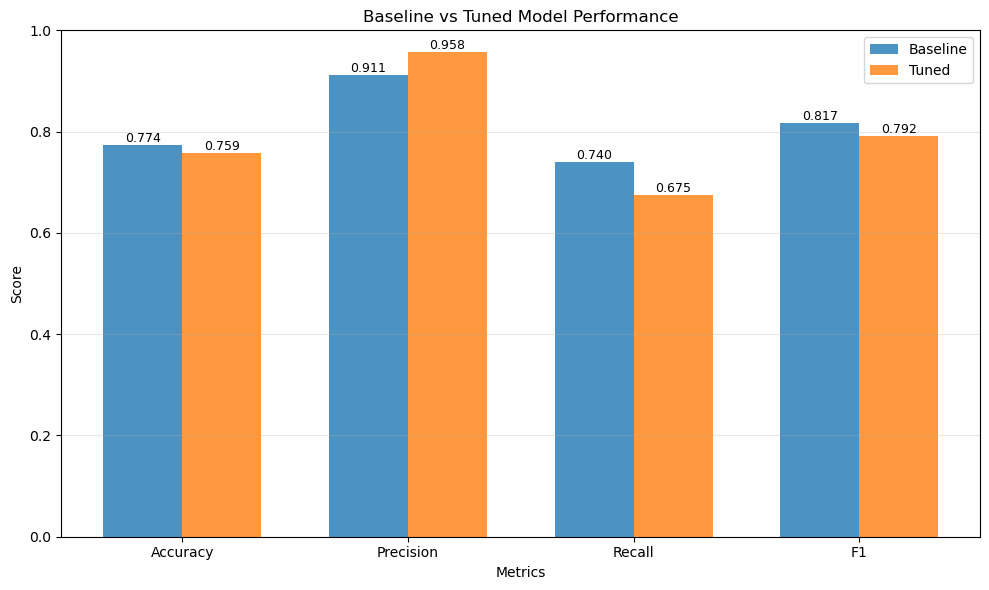

In [10]:
# Bar chart comparison
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1"]
x = np.arange(len(metrics_to_plot))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
baseline_values = [baseline_metrics[m] for m in metrics_to_plot]
tuned_values = [tuned_metrics[m] for m in metrics_to_plot]

bars1 = ax.bar(x - width/2, baseline_values, width, label='Baseline', alpha=0.8)
bars2 = ax.bar(x + width/2, tuned_values, width, label='Tuned', alpha=0.8)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Baseline vs Tuned Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot)
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 10. Save Best Model

In [ ]:
MODEL_SAVE_PATH = r"D:\NLP_ResearchPaper_work\best_tuned_model.pkl"
joblib.dump(best_model, MODEL_SAVE_PATH)
print(f"Best tuned model saved to {MODEL_SAVE_PATH}")

## 11. XGBoost Model (Better Non-Linear Classifier)
Replace Logistic Regression with XGBoost to capture complex patterns.

In [11]:
# Install XGBoost if not already available
try:
    import xgboost as xgb
    print("XGBoost already installed.")
except ImportError:
    print("Installing XGBoost...")
    import subprocess
    subprocess.check_call(["pip", "install", "xgboost"])
    import xgboost as xgb
    print("XGBoost installed successfully.")

Installing XGBoost...
XGBoost installed successfully.


In [12]:
from xgboost import XGBClassifier

# XGBoost pipeline with same preprocessing
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            max_features=20000,
            ngram_range=(1, 2),
            stop_words="english",
            min_df=2
        ), text_feature),
        ("num", StandardScaler(), num_features)
    ]
)

xgb_model = Pipeline([
    ("preprocessor", xgb_preprocessor),
    ("clf", XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=2.14,  # Adjust for class imbalance (4998/2337)
        random_state=SEED,
        n_jobs=-1,
        eval_metric='logloss'
    ))
])

print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)
print("XGBoost training complete.")

Training XGBoost model...
XGBoost training complete.


In [13]:
# XGBoost Evaluation
xgb_pred = xgb_model.predict(X_test)
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]

xgb_metrics = {
    "Accuracy": accuracy_score(y_test, xgb_pred),
    "Precision": precision_score(y_test, xgb_pred),
    "Recall": recall_score(y_test, xgb_pred),
    "F1": f1_score(y_test, xgb_pred)
}

print("XGBoost Results:")
for k, v in xgb_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nClassification Report:\n", classification_report(y_test, xgb_pred))

XGBoost Results:
Accuracy: 0.9903
Precision: 0.9862
Recall: 0.9998
F1: 0.9929

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      2337
           1       0.99      1.00      0.99      4998

    accuracy                           0.99      7335
   macro avg       0.99      0.98      0.99      7335
weighted avg       0.99      0.99      0.99      7335



## 12. FinBERT Model (Pre-trained Financial Transformer)
Use FinBERT embeddings instead of TF-IDF for better financial text understanding.

In [ ]:
# Install transformers and torch if not available
try:
    from transformers import AutoTokenizer, AutoModel
    import torch
    print("Transformers and PyTorch already installed.")
except ImportError:
    print("Installing transformers and torch...")
    import subprocess
    subprocess.check_call(["pip", "install", "transformers", "torch"])
    from transformers import AutoTokenizer, AutoModel
    import torch
    print("Installation complete.")

Installing transformers and torch...


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load FinBERT model
print("Loading FinBERT model...")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_model = AutoModel.from_pretrained("ProsusAI/finbert")

# Set to evaluation mode
finbert_model.eval()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finbert_model.to(device)
print(f"FinBERT loaded on {device}")

In [ ]:
# Function to extract FinBERT embeddings
def get_finbert_embeddings(texts, batch_size=16):
    embeddings = []
    
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            # Tokenize
            inputs = tokenizer(
                batch_texts.tolist(),
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors="pt"
            ).to(device)
            
            # Get embeddings
            outputs = finbert_model(**inputs)
            # Use [CLS] token embedding (first token)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)
            
            if (i // batch_size + 1) % 10 == 0:
                print(f"Processed {i + len(batch_texts)}/{len(texts)} texts")
    
    return np.vstack(embeddings)

print("Extracting FinBERT embeddings for training set...")
X_train_finbert = get_finbert_embeddings(X_train[text_feature])
print(f"Train embeddings shape: {X_train_finbert.shape}")

print("\nExtracting FinBERT embeddings for test set...")
X_test_finbert = get_finbert_embeddings(X_test[text_feature])
print(f"Test embeddings shape: {X_test_finbert.shape}")

In [ ]:
# Combine FinBERT embeddings with numerical features
X_train_finbert_full = np.hstack([
    X_train_finbert,
    X_train[num_features].values
])

X_test_finbert_full = np.hstack([
    X_test_finbert,
    X_test[num_features].values
])

# Scale the combined features
from sklearn.preprocessing import StandardScaler
scaler_finbert = StandardScaler()
X_train_finbert_scaled = scaler_finbert.fit_transform(X_train_finbert_full)
X_test_finbert_scaled = scaler_finbert.transform(X_test_finbert_full)

print(f"Combined feature shape: {X_train_finbert_scaled.shape}")

In [ ]:
# Train Logistic Regression on FinBERT embeddings
finbert_clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=SEED
)

print("Training FinBERT + LogisticRegression model...")
finbert_clf.fit(X_train_finbert_scaled, y_train)
print("Training complete.")

In [ ]:
# FinBERT Evaluation
finbert_pred = finbert_clf.predict(X_test_finbert_scaled)
finbert_prob = finbert_clf.predict_proba(X_test_finbert_scaled)[:, 1]

finbert_metrics = {
    "Accuracy": accuracy_score(y_test, finbert_pred),
    "Precision": precision_score(y_test, finbert_pred),
    "Recall": recall_score(y_test, finbert_pred),
    "F1": f1_score(y_test, finbert_pred)
}

print("FinBERT Results:")
for k, v in finbert_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nClassification Report:\n", classification_report(y_test, finbert_pred))

## 13. Final Comparison (All Models)

In [ ]:
# Create comprehensive comparison table
final_comparison = pd.DataFrame([
    {"Model": "Baseline (TF-IDF + LR)", **baseline_metrics},
    {"Model": "Tuned (TF-IDF + LR)", **tuned_metrics},
    {"Model": "XGBoost (TF-IDF + XGB)", **xgb_metrics},
    {"Model": "FinBERT (Embeddings + LR)", **finbert_metrics}
])

# Sort by F1 score
final_comparison = final_comparison.sort_values("F1", ascending=False)
final_comparison

In [ ]:
# Visualize final comparison
fig, ax = plt.subplots(figsize=(12, 6))

models = final_comparison["Model"].tolist()
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1"]
x = np.arange(len(models))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    values = final_comparison[metric].tolist()
    ax.bar(x + i*width - width*1.5, values, width, label=metric, alpha=0.8)

ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Comprehensive Model Performance Comparison', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 14. Save Best Overall Model

In [ ]:
# Determine best model by F1 score
best_model_name = final_comparison.iloc[0]["Model"]
best_f1 = final_comparison.iloc[0]["F1"]

print(f"Best Model: {best_model_name}")
print(f"Best F1 Score: {best_f1:.4f}")

# Save the best model
if "XGBoost" in best_model_name:
    joblib.dump(xgb_model, r"D:\NLP_ResearchPaper_work\best_overall_model.pkl")
    print("XGBoost model saved.")
elif "FinBERT" in best_model_name:
    joblib.dump(finbert_clf, r"D:\NLP_ResearchPaper_work\best_overall_model.pkl")
    joblib.dump(scaler_finbert, r"D:\NLP_ResearchPaper_work\finbert_scaler.pkl")
    print("FinBERT model and scaler saved.")
elif "Tuned" in best_model_name:
    joblib.dump(best_model, r"D:\NLP_ResearchPaper_work\best_overall_model.pkl")
    print("Tuned LR model saved.")
else:
    joblib.dump(baseline_model, r"D:\NLP_ResearchPaper_work\best_overall_model.pkl")
    print("Baseline model saved.")